# Loan Prediction Model - Comprehensive Analysis

### Overview
This notebook aims to predict **loan default status** using various machine learning models, including:
- **Logistic Regression**
- **Random Forest**
- **XGBoost**

We will compare these models using key metrics:  
✔ Accuracy  
✔ F1-score  
✔ AUC-ROC  

### Challenges with a Small Dataset
A small dataset can cause:  
1. **Overfitting** - Models may memorize patterns instead of generalizing.  
2. **Poor ROC-AUC scores** - Limited diversity in the data makes distinguishing between classes difficult.  
3. **Imbalanced class issues** - If one class is dominant, models struggle to learn the minority class.  

### Possible Solutions  
✔ **More data collection** - Gather more real-world data.  
✔ **Synthetic data generation** - Use SMOTE (Synthetic Minority Over-sampling Technique).  
✔ **Feature engineering** - Extract new meaningful features to boost model performance.  
✔ **Cross-validation** - Ensures models generalize well.  

---

#### Import necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import pickle


##### Load the dataset


In [2]:
file_path = "loan_default_data.csv"
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Info:")
df.info()

# Show first few rows
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 1 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   customer_id, age, income, loan_amount, credit_score, loan_status  5 non-null      object
dtypes: object(1)
memory usage: 172.0+ bytes


,"customer_id, age, income, loan_amount, credit_score, loan_status"
0,"101, 25, 55000, 12000, 680, 0"
1,"102, 40, 72000, 25000, 750, 1"
2,"103, 34, 61000, 18000, 710, 0"
3,"104, 29, 50000, 15000, 640, 1"
4,"105, 50, 80000, 30000, 780, 0"


### Exploratory Data Analysis (EDA)

#### Check for missing values


In [3]:
df.isnull().sum()

customer_id, age, income, loan_amount, credit_score, loan_status    0
dtype: int64

In [4]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 Series([], dtype: int64)


#### Since the data is merged into one column, will read it with a different separator (A comma separator)

In [5]:
df = pd.read_csv(file_path, sep=",", engine="python", header=0)

In [6]:
df = pd.read_csv(file_path, sep=",", engine="python", skipinitialspace=True)

# Beacuse the data is in a single column, we force splitting manually
if df.shape[1] == 1:
    df = pd.read_csv(file_path, sep=",", engine="python", header=None, skipinitialspace=True)

    # Split the first column into multiple columns
    df = df[0].str.split(",", expand=True)

    # Assign column names manually
    df.columns = ["customer_id", "age", "income", "loan_amount", "credit_score", "loan_status"]

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Print to verify the structure
print("Columns detected:", df.columns)
df.head()

Columns detected: Index(['customer_id', 'age', 'income', 'loan_amount', 'credit_score',
       'loan_status'],
      dtype='object')


,customer_id,age,income,loan_amount,credit_score,loan_status
0,customer_id,age,income,loan_amount,credit_score,loan_status
1,101,25,55000,12000,680,0
2,102,40,72000,25000,750,1
3,103,34,61000,18000,710,0
4,104,29,50000,15000,640,1


##### Remove duplicate header row if detected


- Check if the first row contains duplicated column names and remove it
- Check if all elements in the first row are non-numeric (header)
- Drop the first row and reset index


In [7]:
if df.iloc[0].str.match(r'^\D+$').all():  
    df = df[1:].reset_index(drop=True)  

# Convert numeric columns to appropriate data types
df = df.apply(pd.to_numeric, errors='ignore')

# Print to verify the structure
print("Columns detected:", df.columns)
df.head()

Columns detected: Index(['customer_id', 'age', 'income', 'loan_amount', 'credit_score',
       'loan_status'],
      dtype='object')


C:\Users\IDA\AppData\Local\Temp\ipykernel_14288\4233481396.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


,customer_id,age,income,loan_amount,credit_score,loan_status
0,101,25,55000,12000,680,0
1,102,40,72000,25000,750,1
2,103,34,61000,18000,710,0
3,104,29,50000,15000,640,1
4,105,50,80000,30000,780,0


In [8]:
df.isnull().sum()

customer_id     0
age             0
income          0
loan_amount     0
credit_score    0
loan_status     0
dtype: int64

#### Visualize distribution of numerical features


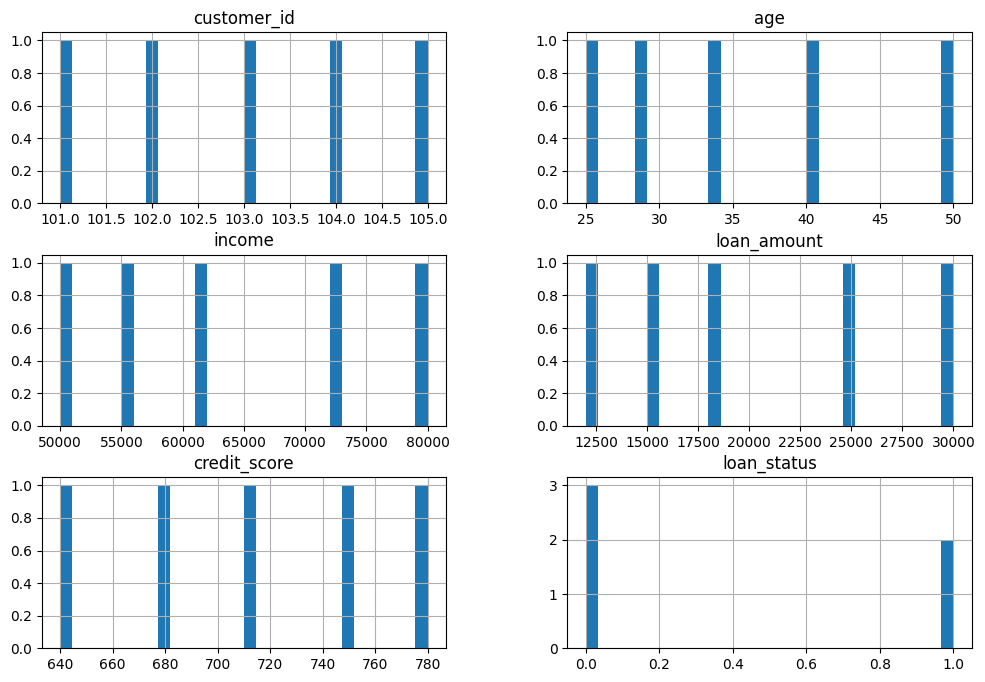

In [9]:
df.hist(figsize=(12, 8), bins=30)
plt.show()


#### Check correlation between numerical features


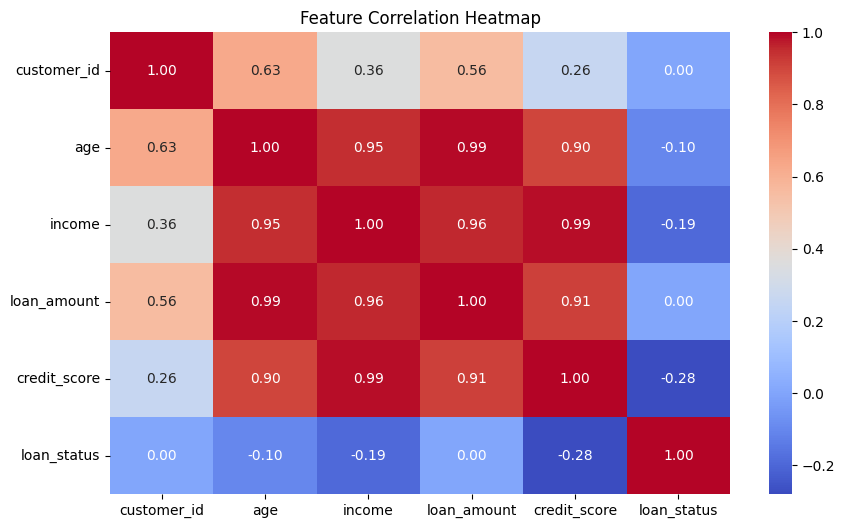

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


## Data Preprocessing

Drop 'customer_id' as it's not relevant for prediction



In [11]:
df = df.drop(columns=["customer_id"])

#### Define features (X) and target (y)


##### Define independent (X) and dependent (y) variables


'loan_status' is the target variable

loan_status (0 = Not Approved, 1 = Approved) → This is what we are predicting!

In [12]:
X = df[['age', 'income', 'loan_amount', 'credit_score']] 
y = df['loan_status'] 

#### Split into train and test sets


In [13]:
test_size = max(0.2, 2 / len(df))  # Ensures at least 2 test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)


### Standardize the feature variables

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Train and Evaluate Multiple Classification Models


1. Logistic Regression

##### Initialize and train the model


In [15]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

##### Make predictions


In [16]:
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1] 

Check for single-class issue before computing AUC

In [17]:
if len(np.unique(y_test)) > 1:  
    log_auc = roc_auc_score(y_test, y_prob_log)
else:
    log_auc = None  # AUC is undefined for single-class test sets

##### Evaluate the model


In [18]:
log_accuracy = accuracy_score(y_test, y_pred_log)
log_f1 = f1_score(y_test, y_pred_log)

print(f"Logistic Regression - Accuracy: {log_accuracy:.4f}, F1-score: {log_f1:.4f}, AUC-ROC: {log_auc}")

Logistic Regression - Accuracy: 0.5000, F1-score: 0.0000, AUC-ROC: 1.0


### Random Forest

##### Initialize and train the model


In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### Make predictions


In [20]:
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

##### Check for single-class issue before computing AUC


In [21]:
rf_auc = roc_auc_score(y_test, y_prob_rf) if len(np.unique(y_test)) > 1 else None


##### Evaluate the model


In [22]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_prob_rf)

print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, F1-score: {rf_f1:.4f}, AUC-ROC: {rf_auc:.4f}")

Random Forest - Accuracy: 0.5000, F1-score: 0.0000, AUC-ROC: 0.5000


### XGBoost

#### Initialize and train the model

In [23]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

C:\Users\IDA\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [04:23:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

##### Make predictions


In [24]:
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

##### Check for single-class issue before computing AUC

In [25]:
xgb_auc = roc_auc_score(y_test, y_prob_xgb) if len(np.unique(y_test)) > 1 else None


##### Evaluate the model


In [26]:
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)

print(f"XGBoost - Accuracy: {xgb_accuracy:.4f}, F1-score: {xgb_f1:.4f}, AUC-ROC: {xgb_auc:.4f}")

XGBoost - Accuracy: 0.5000, F1-score: 0.0000, AUC-ROC: 0.5000


### Compare Model Performance


##### Create a DataFrame for comparison


In [27]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [log_accuracy, rf_accuracy, xgb_accuracy],
    "F1-score": [log_f1, rf_f1, xgb_f1],
    "AUC-ROC": [log_auc, rf_auc, xgb_auc]
})

# Sort by AUC-ROC
results = results.sort_values(by="AUC-ROC", ascending=False)

# Display results
print(results)


                 Model  Accuracy  F1-score  AUC-ROC
0  Logistic Regression       0.5       0.0      1.0
1        Random Forest       0.5       0.0      0.5
2              XGBoost       0.5       0.0      0.5


### Save the models


In [28]:
import pickle

# Save Logistic Regression model
with open("logistic_model.pkl", "wb") as file:
    pickle.dump(log_model, file)

# Save Random Forest model
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

# Save XGBoost model
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(xgb_model, file)

print("Models saved successfully!")


Models saved successfully!


### Save the Trained Model for deployment

In [29]:
import joblib

# Save the trained model (Random Forest)
joblib.dump(rf_model, "loan_default_model.pkl")

# Save the scaler used for feature transformation
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']